<a href="https://colab.research.google.com/github/skitw427/Layerwise-XAI/blob/main/notebook_demo/ResNet18_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import timm
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import matplotlib.pylab as plt
import numpy as np
import random
import ast

import shap

Device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

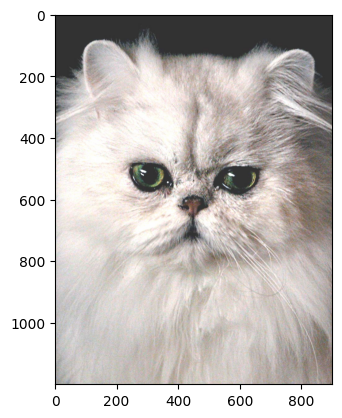

Top-5 Predictions:
Class: Persian cat, Probability: 1.0000
Class: lynx, catamount, Probability: 0.0000
Class: kite, Probability: 0.0000
Class: teddy, teddy bear, Probability: 0.0000
Class: crossword puzzle, crossword, Probability: 0.0000


In [2]:
def load_imagenet_classes(filepath):
    with open(filepath, "r") as f:
        classes = ast.literal_eval(f.read())
    return classes

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return image

def generate_random_image(size=(224, 224, 3)):
    random_image = np.random.randint(0, 256, size=size, dtype=np.uint8)
    return Image.fromarray(random_image)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model_name = "resnet18.a1_in1k"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = timm.create_model(model_name, pretrained=True)
model = model.to(device)
model.eval()

imagenet_classes_path = "imagenet_classes.txt"
imagenet_classes = load_imagenet_classes(imagenet_classes_path)

image_path = "cat.jpg"

image = load_image(image_path)
plt.imshow(image)
plt.show()

input_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_tensor)

softmax = torch.nn.Softmax(dim=1)
predictions = softmax(output)
top5_prob, top5_catid = torch.topk(predictions, 5)

print("Top-5 Predictions:")
for i in range(5):
    class_id = top5_catid[0][i].item()
    probability = top5_prob[0][i].item()
    class_name = imagenet_classes[class_id] if class_id < len(imagenet_classes) else "Unknown"
    print(f"Class: {class_name}, Probability: {probability:.4f}")


In [3]:
import os

image_dir = 'cat_train/'

image_tensors = []
for filename in os.listdir(image_dir):
    if filename.endswith('.JPEG'):
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image)
        image_tensors.append(image_tensor)

if image_tensors:
    train_input_tensor = torch.stack(image_tensors)
    print(f"Input tensor shape: {train_input_tensor.shape}")
else:
    print("No JPEG images found in the specified directory.")


image_dir = 'cat/'

image_tensors = []
for filename in os.listdir(image_dir):
    if filename.endswith('.JPEG'):
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image)
        image_tensors.append(image_tensor)

if image_tensors:
    val_input_tensor = torch.stack(image_tensors)
    print(f"Input tensor shape: {val_input_tensor.shape}")
else:
    print("No JPEG images found in the specified directory.")

Input tensor shape: torch.Size([41, 3, 224, 224])
Input tensor shape: torch.Size([8, 3, 224, 224])


In [4]:
import torch.nn as nn

for name, module in model.named_modules():
    if isinstance(module, nn.ReLU):
        module.inplace = False

# print(model)

In [8]:
import time

background = train_input_tensor[:15]
test_images = val_input_tensor[4:7]

background = background.to(device)
test_images = test_images.to(device)

# 실행 시간 측정 시작
start_time = time.time()45

e = shap.GradientExplainer(model, background)
shap_values = e.shap_values(test_images)

# 실행 시간 측정 종료
end_time = time.time()

# 실행 시간 출력
print(f"shap_values 계산에 걸린 시간: {end_time - start_time:.2f}초")


shap_values 계산에 걸린 시간: 1821.02초


In [9]:
mean = [0.485, 0.456, 0.406]
std =  [0.229, 0.224, 0.225]

#index_names = [['jackfruit', 'custard apple', 'pomegranate', 'hay', 'carbonara', 'chocolate sauce', 'dough', 'meatloaf'], ['jackfruit', 'custard apple', 'pomegranate', 'hay', 'carbonara', 'chocolate sauce', 'dough', 'meatloaf']]

shap_values_for_class = shap_values[..., 280:289]
shap_numpy = list(np.transpose(shap_values_for_class, (4, 0, 2, 3, 1)))
test_images_np = test_images.detach().cpu().numpy()  # torch.Tensor -> np.ndarray

for b in range(test_images_np.shape[0]):  # 배치 차원 순회
    for c in range(test_images_np.shape[1]):  # 채널(R/G/B)
        test_images_np[b, c, :, :] = test_images_np[b, c, :, :] * std[c] + mean[c]
test_images_np = test_images_np.transpose(0, 2, 3, 1)

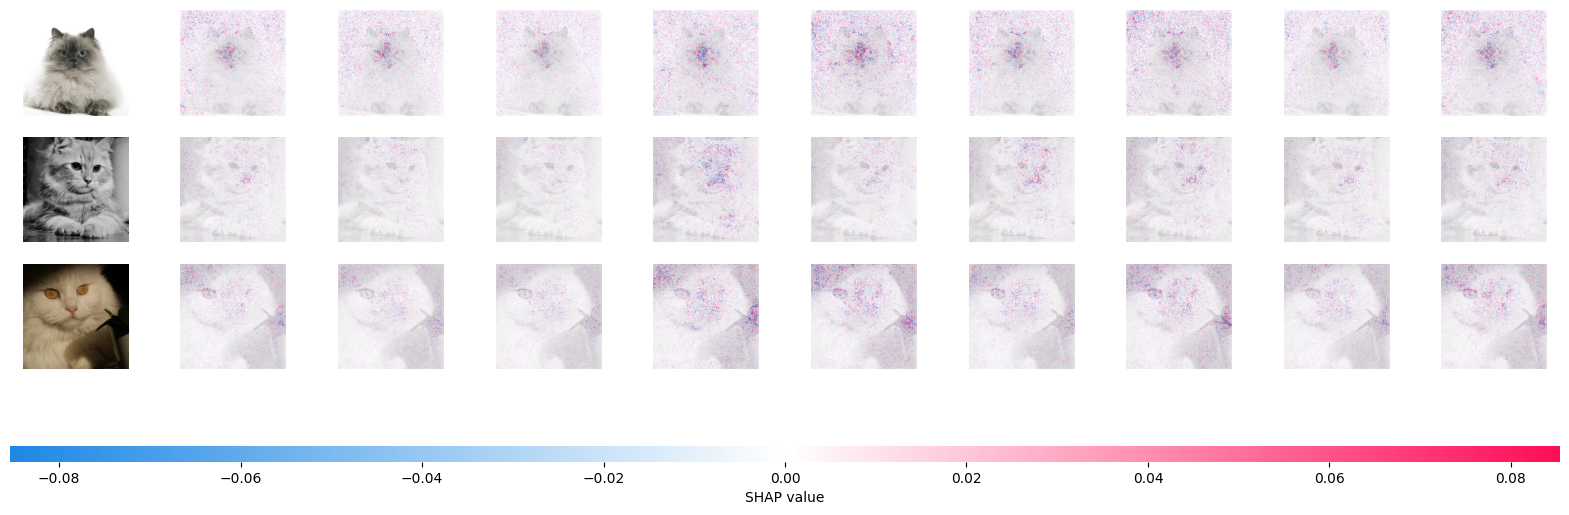

In [10]:
# plot the feature attributions
shap.image_plot(shap_numpy, test_images_np)